- dataset: https://github.com/meinertsen/Hourly-Weatherdata 
- method: https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver, https://docs.scipy.org/doc/scipy/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp
- paper: https://arxiv.org/pdf/1806.08999.pdf 

#### Objective Function:
\begin{equation}
\min _{z, \beta} K\left|z_{k}-T^{s}\right| \beta_{k}+M \beta_{k}^{3} \,\,\,\, ;k = {1,\dots, n}
\end{equation}

#### Constraints:
\begin{align*} 
T^{min} \leq z_{k} \leq T^{max}\\ 
-\frac{z_{eq} -0.5T^{0}}{0.5z_{eq}+T^s} \leq - \beta
\end{align*}

#### Where 
\begin{align*} 
  M &= \frac{ws}{\alpha^3 R^3 c_a^3} &, \,\,\,\, K &= \frac{w}{\eta R} \\
  \alpha &= \frac{\Delta t}{CR} &,  \,\,\,\, \beta &= \alpha R c_a m
\end{align*}

#### Model parameters
- $T^0$ - outside temperature
- $T^s$ - supply temperature
- $Z$ - desired temperature 
- $C$ - thermal capacitance 
- $\mathrm{c_a}$ - specific heat caparifies
- $R$ - thermal resistance of wall and outside
- $m$ - heat flow rate 
- $w$ - weight coefficient
- $\eta$ - coefficient of performance (heat / cold)

- - -
#### Reduced Resistance-Capacitance (RC) model 
\begin{equation}
\begin{aligned}
&T^{k+1}=\left( 1-\frac{\Delta t}{R}-\frac{\Delta t C_{a} m}{C} \right) T^{k}+\frac{\Delta t}{C R} T^{0}+\frac{\Delta t C_{a} m T^{s}}{C}\\
&T^{k+1}=(1-\alpha-\beta) T^{k}+\alpha T^{0}+\beta T^{S} \\
&\text{where}\,\,\,\, \alpha = \frac{\Delta t}{CR} ,  \,\,\,\, \beta = \alpha R c_a m
\end{aligned}
\end{equation}

Considering in steady state
\begin{align*} 
&z_{k+1} = z_k = z_{eq}\\
&z_{eq} = (0.5+\beta)z_{eq} + 0.5T^0 + \beta T^s\\
&- \beta \geq -\frac{z_{eq} -0.5T^{0}}{0.5z_{eq}+T^s}\\
&\text{where}\,\,\,\, \alpha = 0.5
\end{align*}


- - -

## unit
1. $R(\mathbf{m}^{2} \mathbf{K ~ W}^{-1})$ = Thermal resistance between wall and outside
    - $ R=\frac{l}{\lambda} \quad $ where l is the thickness of the material in metres and
    $\lambda$ is the thermal conductivity in $W / \mathrm{mK}$.
    The R-value is measured in metres squared Kelvin per Watt $\left(\mathrm{m}^{2} \mathrm{~K} / \mathrm{W}\right)$ If you insulated this with 80mm thick foil-faced, it would improve the thermal resistance by more than 21 times!
    - In real buildings a wall is made up of many different material layers. The total thermal resistance of the entire wall is calculated by adding the thermal resistance of each separate layer.
    - For example the thermal resistance of 220mm of solid brick wall (with thermal conductivity λ=1.2W/mK) is 0.18 m2K/W. https://www.thegreenage.co.uk/article/thermal-conductivity-r-values-and-u-values-simplified/
    - \begin{equation}
\begin{aligned}
&\text { Table } 5 \text { Thermal resistances for surfaces and air gaps }\\
&\begin{array}{ll}
\hline \text { Layer } & \begin{array}{l}
\text { Ressistance I } \\
\mathbf{m}^{2} \mathbf{K ~ W}^{-1}
\end{array} \\
\hline \text { Inside surface }\left(\mathrm{R}_{\mathrm{si}}\right) & 0.13 \\
\hline \text { Air gap } & 0.18 \\
\hline \text { Outside surface }\left(\mathrm{R}_{\mathrm{so}}\right) & 0.04 \\
\hline
\end{array}
\end{aligned}
\end{equation}
Or it can sum with diff composite material such as $4.67  \,\,\, \mathbf{m}^{2} \mathbf{K ~ W}^{-1}$
<!-- ![](https://cdn.mathpix.com/snip/images/N86-OgWOM-EV-6k_tNSfHuJqPKYO3hToixLUIRO0UrQ.original.fullsize.png) -->
![alt text](resistance_composite.png "Summing thermal resistances") 
https://www.open.edu/openlearn/nature-environment/energy-buildings/content-section-2.2.6
2. $c_a(J g^{-1} K^{-1})$ =  specific heat capacities 
    - air at 25 C = $1.0035 \,\, J g^{-1} K^{-1}$ https://en.wikipedia.org/wiki/Table_of_specific_heat_capacities
3. $C(J/m^3 K)$ = thermal capacitance (for material of wall(P))
    - 1300 (brick wall) 1800 (concrete wall)
    -  is the amount of heat energy required to increase the temperature of the given subunit by one degree.
    - https://www.researchgate.net/publication/309428054_AN_INVESTIGATION_OF_THE_INFLUENCE_OF_THERMOPHYSICAL_PROPERTIES_OF_MULTILAYER_WALLS_AND_ROOFS_ON_THE_DYNAMIC_THERMAL_CHARACTERISTICS/figures?lo=1
    - https://theengineeringmindset.com/specific-heat-capacity-of-materials/   
4. $m_i (kg/s)$ = heat flow rate
    - 0.05 - 0.55 (from paper(P))
    - pretty same as $Q$ in paper (P)
5. $\eta$ = coefficient of performance (no unit)
    - Most air conditioners have a COP of 2.3 to 3.5. https://en.wikipedia.org/wiki/Coefficient_of_performance
6. $w$ = weight coefficient (no unit)
    - 0.03 - 0.50 (got from pump paper page 8 https://docs.lib.purdue.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1893&context=iracc)
7. $s (m^2)$ = cross section area (not sure)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import math 
from scipy.optimize import minimize, Bounds, LinearConstraint 
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import Bounds
plt.rcParams["figure.figsize"] = (18,5)

In [2]:
def opti_t_m(t0, ts, t_initial, z_eq, print_res = True, method_name = 'trust-constr'  ): # trust-constr optimizer
    ''' 
        Temperature in Kelvin
        t0 = outside temperature
        ts = supply temperature from air conditioner units
        t_initial = initial temperature for scipy.optimize
        z_eq = equilibrium temperature at steady state (T_{K+1} = T_K) 
    '''
    def obj_func(q): 
        z = q[:24]
        beta = q[24:] 
        sum_res = np.zeros([1,]) 
        for i in range(24):
            sum_res += K * np.abs(z[i] - ts[i]) + M * beta[i] **2 ##
        return sum_res

    def cons_J_2(q):
        z = np.asarray(q[:24])
        beta = np.asarray(q[24:])

        der_b = np.full((24, ), 3*M)
        for i in range(24):
            fn_i = K*abs(z[i]-ts[i])+3*M*beta[i]**2
            der_b[i] = fn_i
        np_k = np.full((24, ), K)
        der_z = np.multiply(np_k, beta)
        der = np.concatenate((der_z, der_b))
        return der

    def cons_H_2(q):
        z = q[:24]
        beta = q[24:]
        z = np.asarray(z)
        beta = np.asarray(beta)

        H = np.zeros_like(q)
        diagonal = np.zeros_like(q)

        A1 = np.zeros((24, 24)) 

        B1 = np.zeros((24, 24))
        np.fill_diagonal(B1, K)

        C1 = np.zeros((24, 24))
        np.fill_diagonal(C1, K)

        D1 = np.zeros((24, 24))

        list_d = []
        for j in range(24):
            list_d.append(6*M*beta[j]) 
        np.fill_diagonal(D1, list_d)

        upp = np.concatenate((A1,B1),axis=1)
        loww = np.concatenate((C1,D1),axis=1)

        H = np.concatenate((upp, loww))
        return H

    def c_z_f(z_eq):
        z_res = []
        for j,z_eq_i in enumerate(list(z_eq)):
            fun = (z_eq_i - 0.5*t0[j])/(0.5*z_eq_i+ts[j])  
            z_res.append(fun)
        return np.array(z_res)

    kelvin = 273 
    c_z = c_z_f(z_eq)  
    R = 4.67 
    w = 0.4 
    n = 3.0 
    c_a = 1.0003 
    C = 1500 
    del_t = 60*60 # 1 hour --> second
    s = math.pi * 0.2 * 0.2 # cross section area  

    alpha = del_t/(C*R) # ~0.5 
    K = w/(n*R) 
    M = (w*s)/(alpha**3 * R**3 * c_a**3)

    np15 = np.full((24, ), 15+kelvin)
    np25 = np.full((24, ), 25+kelvin)
    np_l_inf = np.full((24, ), 0)
    np_u_inf = np.full((24, ), c_z)
    lb = list(np.concatenate((np15, np_l_inf)))
    ub = list(np.concatenate((np25, np_u_inf)))  
    bounds = Bounds(lb, ub) # 15 <= z <= 25, 0 <= beta <= cz  
    x0 = np.concatenate((t_initial, np.full((24, ), 0.4)))
    if method_name == 'trust-constr':
        res = minimize(obj_func,x0, method=method_name,hess=cons_H_2,jac=cons_J_2,bounds=bounds,options={'disp': True}) 
    if method_name == 'SLSQP':
        res = minimize(obj_func,x0, method='SLSQP',jac=cons_J_2,bounds=bounds,options={'disp': False}) 
    temp_z = res.x[:24]
    beta_res = res.x[24:] 
    mass_flow_rate = np.true_divide(res.x[24:], alpha*R*c_a)
    if print_res == True: 
        print(f"Final Temperature (C):\n", np.subtract(res.x[:24], np.full((24, ), kelvin)))
        print(f"Beta:\n", res.x[24:])
        print(f"Mass flow rate (kg/s):\n", mass_flow_rate)
    return res.x,mass_flow_rate
        
    

In [3]:
def plot_graph(temp_z_trust, temp_z_sls, title_is, t0, ts): 
    hourly = np.linspace(1.0, 24.0, num=24)
#     plt.title(title_is, fontweight="700", fontsize=18)
#     plt.plot(hourly, t_initial-kelvin, label = f"T_0 for scipy opti", linestyle = 'dotted')
    plt.plot(hourly, np.full((24, ), ts-kelvin), label = f"T_supply", linestyle='dashed')
    plt.plot(hourly, np.full((24, ), t0-kelvin), label = f"T_outside", linestyle='dashed')
    plt.plot(hourly, temp_z_trust, label = f"T_Z (method='trust-constr')")
    plt.plot(hourly, temp_z_sls, label = f"T_Z  (method='SLSQP')")
    plt.axhspan(15, 25, facecolor='y', alpha=0.1, label="comfortable zone")
    plt.xlabel(r"$Date \,\,\, (hour)$", fontweight="500", fontsize=16)
    plt.ylabel(r"$Temperature \,\,\, (C)$", fontweight="500", fontsize=16)
    plt.legend(fontsize=12)
    plt.show()
    
    
def plot_graph_mass(mass_trust, mass_sls): 
    hourly = np.linspace(1.0, 24.0, num=24)
#     plt.title(title_is, fontweight="700", fontsize=18)
#     plt.plot(hourly, t_initial-kelvin, label = f"T_0 for scipy opti", linestyle = 'dotted') 
    plt.plot(hourly, mass_trust, label = f"$m_k$ (method='trust-constr')")
    plt.plot(hourly, mass_sls, label = f"$m_k$  (method='SLSQP')") 
    plt.xlabel(r"$Date \,\,\, (hour)$", fontweight="500", fontsize=16)
    plt.ylabel(r"mass flow rate (kg/s)", fontweight="500", fontsize=16)
    plt.legend(fontsize=12)
    plt.show()    

# Spliting into
## 3 cases 
1. hot weather
2. mild weather
3. cold weather


## 2 optmizers
1. Optimizer: Trust-Region Constrained Algorithm (method='trust-constr')
2. Optimizer: Sequential Least SQuares Programming (SLSQP) Algorithm (method='SLSQP')

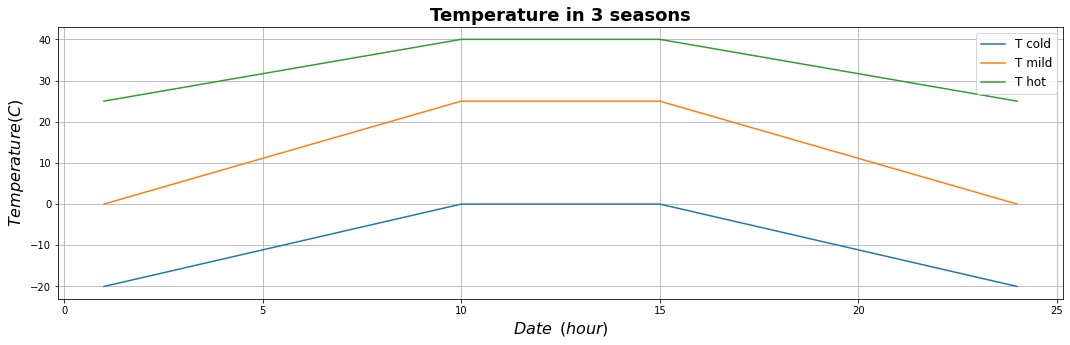

In [4]:
kelvin = 273 
hourly = np.linspace(1.0, 24.0, num=24) 
c1 = np.linspace(-20.0+kelvin, 0.0+kelvin, num=10) 
c2 = np.full((4, ), 0+kelvin)
c3 = np.linspace(0.0+kelvin, -20.0+kelvin, num=10) 
t_c = np.concatenate((c1, c2, c3), axis=None) #np.linspace(-20.0+kelvin, 5.0+kelvin, num=24) 

m1 = np.linspace(0.0+kelvin, 25.0+kelvin, num=10) 
m2 = np.full((4, ), 25+kelvin)
m3 = np.linspace(25.0+kelvin, 0.0+kelvin, num=10) 
t_m = np.concatenate((m1, m2, m3), axis=None)# np.linspace(5.0+kelvin, 20.0+kelvin, num=24)

h1 = np.linspace(25.0+kelvin, 40.0+kelvin, num=10) 
h2 = np.full((4, ), 40+kelvin)
h3 = np.linspace(40.0+kelvin, 25.0+kelvin, num=10) 
t_h = np.concatenate((h1, h2, h3), axis=None)#np.linspace(20.0+kelvin, 35.0+kelvin, num=24)
plt.title("Temperature in 3 seasons", fontweight="700", fontsize=18)
plt.plot(hourly, t_c-kelvin, label = f"T cold")
plt.plot(hourly, t_m-kelvin, label = f"T mild")
plt.plot(hourly, t_h-kelvin, label = f"T hot")
plt.xlabel(r"$Date \,\,\, (hour)$", fontweight="700", fontsize=16)
plt.ylabel(r"$Temperature (C)$", fontweight="700", fontsize=16)
# plt.axhline(y=0, color='tan', linestyle='-.')
plt.legend(fontsize=12)
plt.grid()
plt.show()

### Test case 1: cold day

`xtol` termination condition is satisfied.
Number of iterations: 299, function evaluations: 542, CG iterations: 325, optimality: 4.30e-03, constraint violation: 0.00e+00, execution time: 0.45 s.


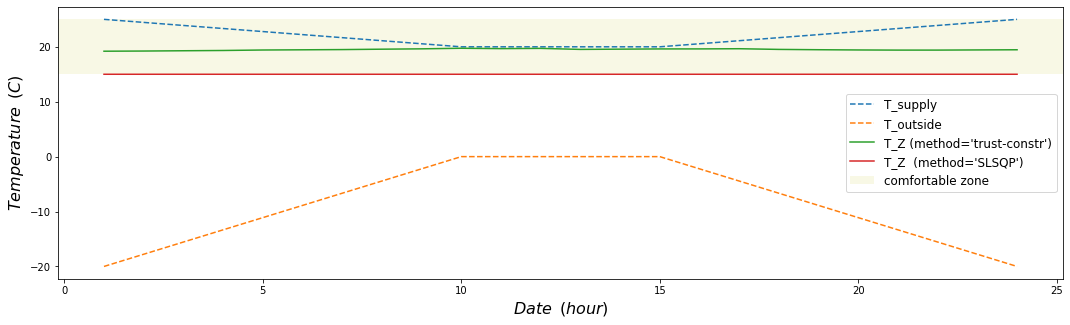

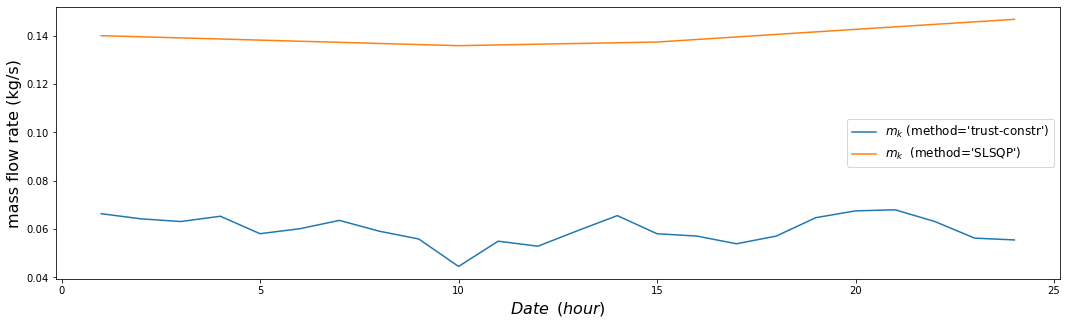

In [5]:
s1 = np.linspace(25.0+kelvin, 20.0+kelvin, num=10) 
s2 = np.full((4, ), 20+kelvin)
s3 = np.linspace(20.0+kelvin, 25.0+kelvin, num=10) 
ts = np.concatenate((s1, s2, s3), axis=None)
# ts = np.linspace(25.0+kelvin, 20.0+kelvin, num=24)
t_initial = np.linspace(-10+kelvin, 0+kelvin, 24) 
z_eq = np.linspace(20.0+kelvin, 30.0+kelvin, num=24)
cold_t,m_c = opti_t_m(t_c, ts, t_initial, z_eq, print_res = False )
cold_t_sls, m_c_sls = opti_t_m(t_c, ts, t_initial, z_eq, print_res = False, method_name = 'SLSQP' )
title_is = "Cold day"


plot_graph(np.subtract(cold_t[:24], np.full((24, ), kelvin)), np.subtract(cold_t_sls[:24], np.full((24, ), kelvin)), title_is, t_c, ts)
plot_graph_mass(m_c, m_c_sls)


### Test case 2: warm day

`xtol` termination condition is satisfied.
Number of iterations: 295, function evaluations: 523, CG iterations: 289, optimality: 4.23e-03, constraint violation: 0.00e+00, execution time:  0.4 s.


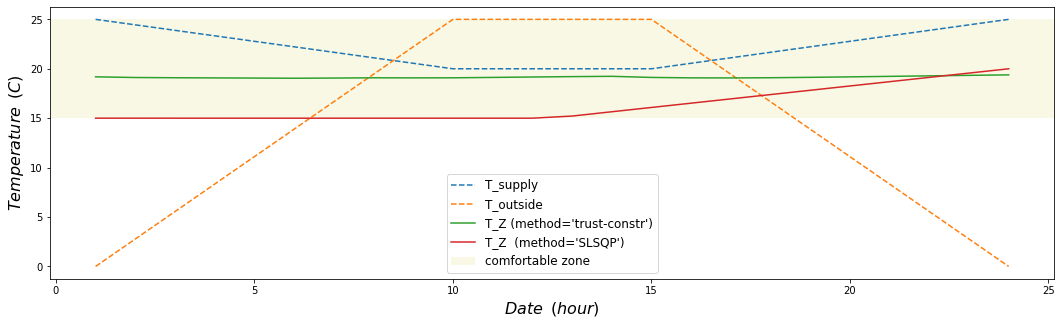

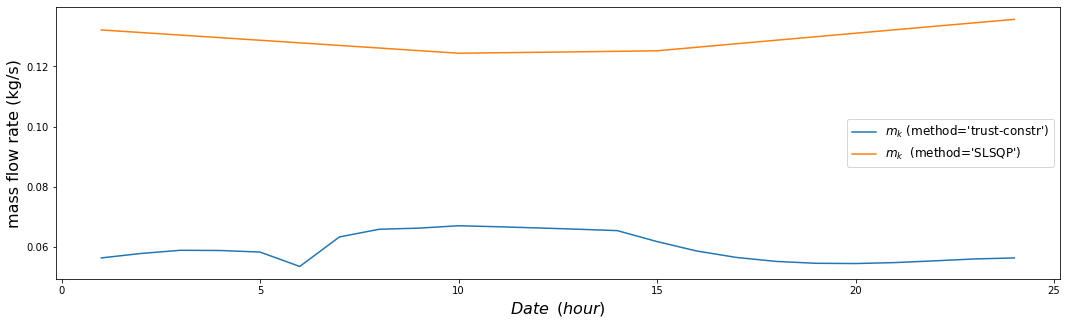

In [6]:
s1 = np.linspace(25.0+kelvin, 20.0+kelvin, num=10) 
s2 = np.full((4, ), 20+kelvin)
s3 = np.linspace(20.0+kelvin, 25.0+kelvin, num=10) 
ts = np.concatenate((s1, s2, s3), axis=None)
# ts = np.linspace(25.0+kelvin, 17.0+kelvin, num=24)
t_initial = np.linspace(10+kelvin, 20+kelvin, 24) 
z_eq = np.linspace(20.0+kelvin, 25.0+kelvin, num=24)
warm_t,m_w = opti_t_m(t_m, ts, t_initial, z_eq, print_res = False )
warm_t_sls, m_w_sls = opti_t_m(t_m, ts, t_initial, z_eq, print_res = False, method_name = 'SLSQP' )
title_is = "Warm day"
plot_graph(np.subtract(warm_t[:24], np.full((24, ), kelvin)),np.subtract(warm_t_sls[:24], np.full((24, ), kelvin)), title_is,t_m, ts)
plot_graph_mass(m_w, m_w_sls)


### Test case 3: hot day

`xtol` termination condition is satisfied.
Number of iterations: 271, function evaluations: 498, CG iterations: 280, optimality: 2.13e-03, constraint violation: 0.00e+00, execution time: 0.59 s.


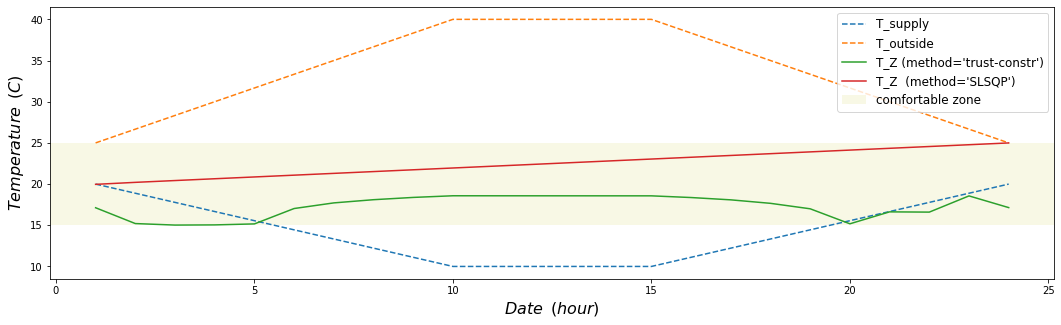

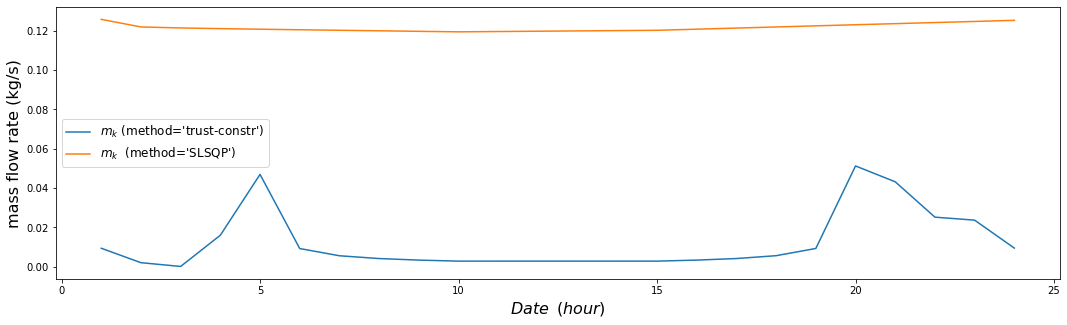

In [7]:
s1 = np.linspace(20.0+kelvin, 10.0+kelvin, num=10) 
s2 = np.full((4, ), 10+kelvin)
s3 = np.linspace(10.0+kelvin, 20.0+kelvin, num=10) 
ts = np.concatenate((s1, s2, s3), axis=None)
# ts = np.linspace(18.0+kelvin, 15.0+kelvin, num=24)
t_initial = np.linspace(20+kelvin, 25+kelvin, 24) 
z_eq = np.linspace(20.0+kelvin, 25.0+kelvin, num=24)
hot_t,m_h = opti_t_m(t_h, ts, t_initial, z_eq, print_res = False )
hot_t_sls,m_h_sls = opti_t_m(t_h, ts, t_initial, z_eq, print_res = False, method_name = 'SLSQP' )


title_is = "Hot day"
plot_graph(np.subtract(hot_t[:24], np.full((24, ), kelvin)),np.subtract(hot_t_sls[:24], np.full((24, ), kelvin)), title_is,t_h, ts)
plot_graph_mass(m_h, m_h_sls)


### Test case 4: fluctuated temperature

`xtol` termination condition is satisfied.
Number of iterations: 271, function evaluations: 507, CG iterations: 265, optimality: 4.22e-03, constraint violation: 0.00e+00, execution time: 0.51 s.


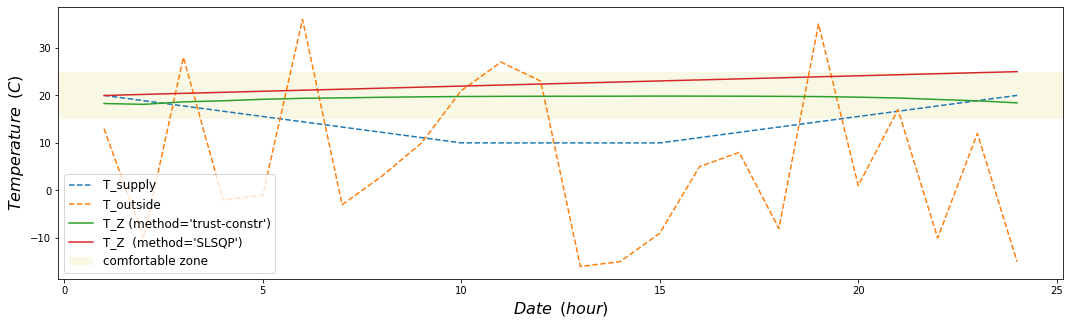

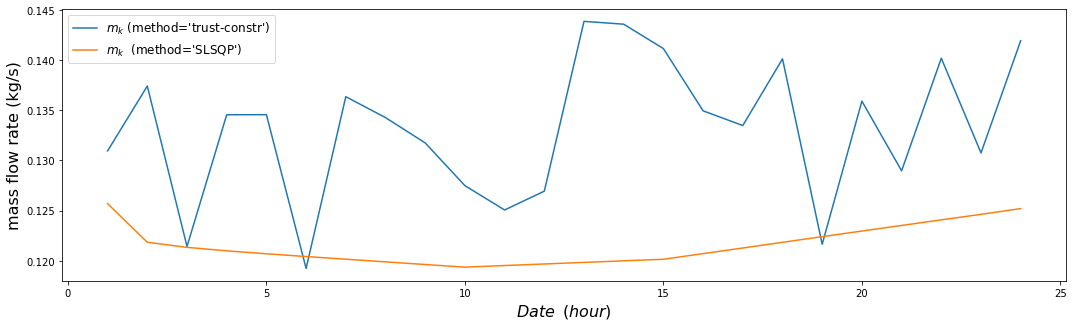

In [8]:
s1 = np.linspace(20.0+kelvin, 10.0+kelvin, num=10) 
s2 = np.full((4, ), 10+kelvin)
s3 = np.linspace(10.0+kelvin, 20.0+kelvin, num=10) 
ts = np.concatenate((s1, s2, s3), axis=None)
# ts = np.linspace(18.0+kelvin, 15.0+kelvin, num=24)
t_f = np.random.randint(-20, 40, 24) + kelvin
t_initial = np.linspace(20+kelvin, 25+kelvin, 24) 
z_eq = np.linspace(20.0+kelvin, 25.0+kelvin, num=24)
hot_t,m_h = opti_t_m(t_f, ts, t_initial, z_eq, print_res = False )
hot_t_sls,m_h = opti_t_m(t_f, ts, t_initial, z_eq, print_res = False, method_name = 'SLSQP' )

plot_graph(np.subtract(hot_t[:24], np.full((24, ), kelvin)),np.subtract(hot_t_sls[:24], np.full((24, ), kelvin)), title_is,t_f, ts)
plot_graph_mass(m_h, m_h_sls)



- - - -

In [9]:
plt.rcParams["figure.figsize"] = (35,12)

def comp_para(R= 4.67 ,w= 0.4 ,n= 3.0,C = 1500  ,c_a= 1.0003 ,s = math.pi * 0.2 * 0.2):
    '''
    R = 4.67 
    w = 0.4 
    n = 3.0 
    c_a = 1.0003 
    C = 1500  
    s = math.pi * 0.2 * 0.2 # cross section area (not sure!)
    
    '''
    def obj_func(q): 
        z = q[:24]
        beta = q[24:] 
        sum_res = np.zeros([1,]) 
        for i in range(24):
            sum_res += K * np.abs(z[i] - ts[i]) + M * beta[i] **2
        return sum_res

    def cons_J_2(q):
        z = np.asarray(q[:24])
        beta = np.asarray(q[24:])

        der_b = np.full((24, ), 3*M)
        for i in range(24):
            fn_i = K*abs(z[i]-ts[i])+3*M*beta[i]**2
            der_b[i] = fn_i
        np_k = np.full((24, ), K)
        der_z = np.multiply(np_k, beta)
        der = np.concatenate((der_z, der_b))
        return der

    def cons_H_2(q):
        z = q[:24]
        beta = q[24:]
        z = np.asarray(z)
        beta = np.asarray(beta)

        H = np.zeros_like(q)
        diagonal = np.zeros_like(q)

        A1 = np.zeros((24, 24)) 

        B1 = np.zeros((24, 24))
        np.fill_diagonal(B1, K)

        C1 = np.zeros((24, 24))
        np.fill_diagonal(C1, K)

        D1 = np.zeros((24, 24))

        list_d = []
        for j in range(24):
            list_d.append(6*M*beta[j]) 
        np.fill_diagonal(D1, list_d)

        upp = np.concatenate((A1,B1),axis=1)
        loww = np.concatenate((C1,D1),axis=1)

        H = np.concatenate((upp, loww))
        return H

    def c_z_f(z_eq):
        z_res = []
        for j,z_eq_i in enumerate(list(z_eq)):
            fun = (z_eq_i - 0.5*t0[j])/(0.5*z_eq_i+ts[j])  
            z_res.append(fun)
        return np.array(z_res)

    kelvin = 273
    c1 = np.linspace(-20.0+kelvin, 0.0+kelvin, num=10) 
    c2 = np.full((4, ), 0+kelvin)
    c3 = np.linspace(0.0+kelvin, -20.0+kelvin, num=10) 
    t0 = np.concatenate((c1, c2, c3), axis=None) #np.linspace(-20.0+kelvin, 5.0+kelvin, num=24) 

    s1 = np.linspace(25.0+kelvin, 20.0+kelvin, num=10) 
    s2 = np.full((4, ), 20+kelvin)
    s3 = np.linspace(20.0+kelvin, 25.0+kelvin, num=10) 
    ts = np.concatenate((s1, s2, s3), axis=None)

    z_eq = np.linspace(20.0+kelvin, 25.0+kelvin, num=24)
    c_z = c_z_f(z_eq)  
    del_t = 60*60 # 1 hour --> second
    alpha = del_t/(C*R) # ~0.5 
    K = w/(n*R) 
    M = (w*s)/(alpha**3 * R**3 * c_a**3)

    np15 = np.full((24, ), 15+kelvin)
    np25 = np.full((24, ), 25+kelvin)
    np_l_inf = np.full((24, ), 0)
    np_u_inf = np.full((24, ), c_z)
    lb = list(np.concatenate((np15, np_l_inf)))
    ub = list(np.concatenate((np25, np_u_inf)))  
    bounds = Bounds(lb, ub) # 15 <= z <= 25, 0 <= beta <= cz 
    t_initial = np.linspace(15+kelvin, 25+kelvin, 24) 
    x0 = np.concatenate((t_initial, np.full((24, ), 0.4)))

    res = minimize(obj_func,x0, method='SLSQP',jac=cons_J_2,bounds=bounds,options={'disp': True}) 
    temp_z = res.x[:24]
    beta_res = res.x[24:] 
    mass_flow_rate = np.true_divide(res.x[24:], alpha*R*c_a)
    return res.x[:24]-273, mass_flow_rate
# print(f"Final Temperature (C):\n", np.subtract(res.x[:24], np.full((24, ), kelvin)))
# print(f"Beta:\n", res.x[24:])
# print(f"Mass flow rate (kg/s):\n", mass_flow_rate)

def plot_para(t1,t2,m1,m2, name_title, name_label1, name_label2):
    plt.rcParams['font.size'] = '23'
    fig, (ax1, ax2) = plt.subplots(2) 
    fig.suptitle(name_title, fontsize=35)
    hourly = np.linspace(1.0, 24.0, num=24) 
#     ax1.plot(hourly, np.full((24, ), ts-kelvin), label = f"T_supply", linestyle='dashed')
#     ax1.plot(hourly, np.full((24, ), t0-kelvin), label = f"T_outside", linestyle='dashed') 
    ax1.plot(hourly, t1, label = f"$T_{1}; {name_label1}$")
    ax1.plot(hourly, t2, label = f"$T_{2}; {name_label2}$")
    ax1.axhspan(15, 25, facecolor='y', alpha=0.1, label="comfortable zone")
    ax1.set_xlabel(r"$Date \,\,\, (hour)$", fontweight="500", fontsize=25)  
    ax1.set_ylabel(r"$Temperature \,\,\, (C)$", fontweight="500", fontsize=25)
    ax1.legend(fontsize=25) 
    
    ax2.plot(hourly, m1, label = f"$m_{1} ; {name_label1}$") 
    ax2.plot(hourly, m2, label = f"$m_{2} ; {name_label2}$") 
    ax2.set_xlabel(r"$Date \,\,\, (hour)$", fontweight="500", fontsize=25)
    ax2.set_ylabel(r"mass flow rate (kg/s)", fontweight="500", fontsize=25)
    ax2.set_yscale('log')
    ax2.legend(fontsize=25) 

Optimization terminated successfully    (Exit mode 0)
            Current function value: [82.10184925]
            Iterations: 64
            Function evaluations: 582
            Gradient evaluations: 60
Iteration limit reached    (Exit mode 9)
            Current function value: [0.83904035]
            Iterations: 100
            Function evaluations: 1065
            Gradient evaluations: 100


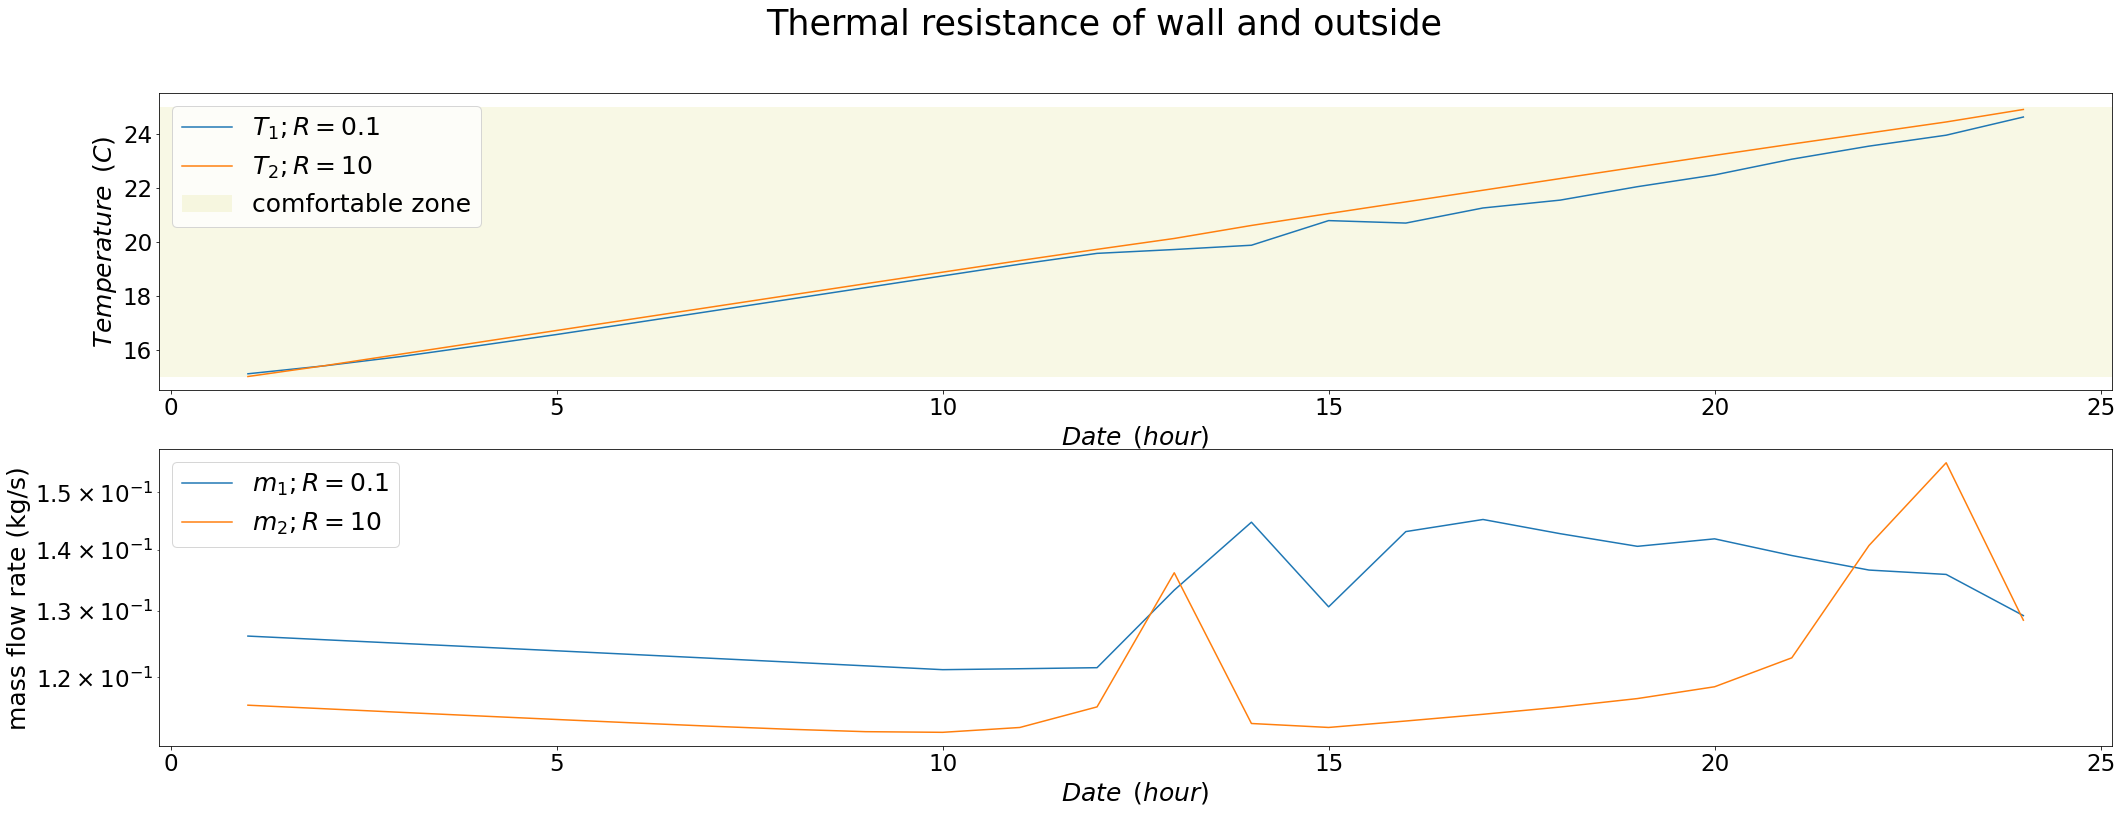

In [10]:
name_title = "Thermal resistance of wall and outside"
name_label1 = "R=0.1"
name_label2 = "R=10"
t_1, m_1 = comp_para(R = 0.1 )
t_2, m_2 = comp_para(R = 10 )
plot_para(t_1,t_2,m_1,m_2,name_title, name_label1, name_label2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: [0.13495364]
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration limit reached    (Exit mode 9)
            Current function value: [2.23504994]
            Iterations: 100
            Function evaluations: 1065
            Gradient evaluations: 99


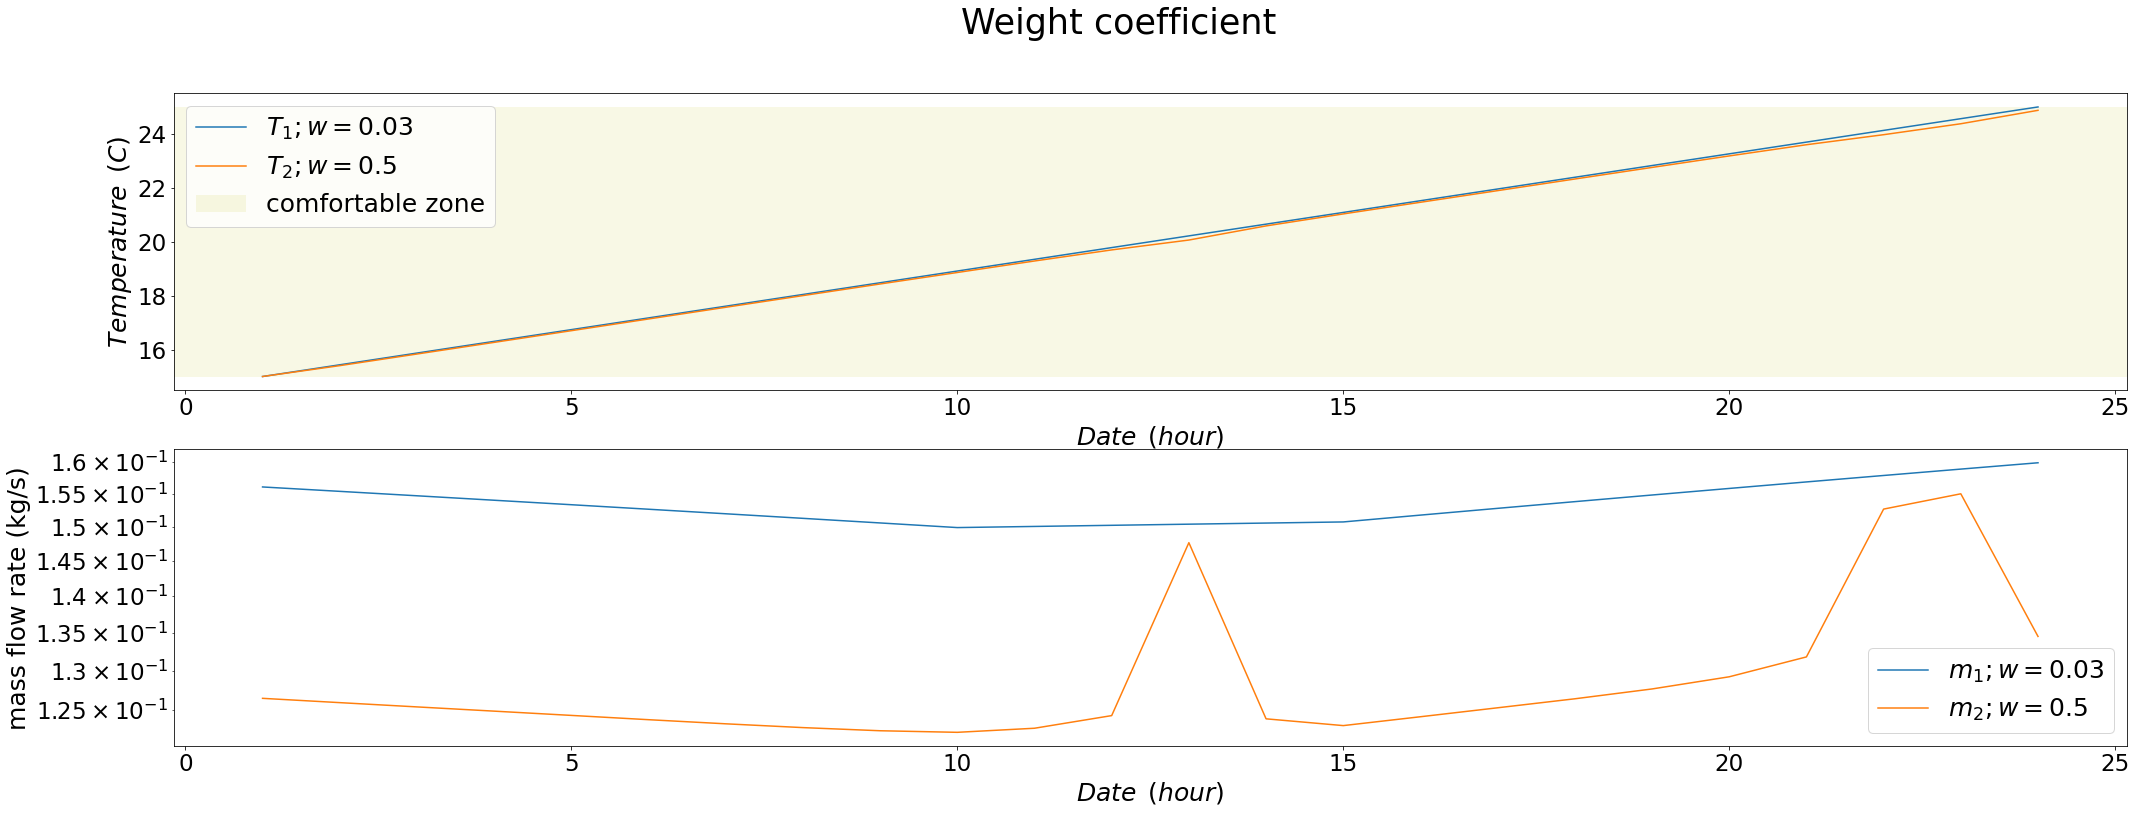

In [11]:
name_title = "Weight coefficient"
name_label1 = "w=0.03"
name_label2 = "w=0.5"
t_1, m_1 = comp_para(w= 0.03 )
t_2, m_2 = comp_para(w= 0.5 )
plot_para(t_1,t_2,m_1,m_2,name_title, name_label1, name_label2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: [2.13986041]
            Iterations: 97
            Function evaluations: 1036
            Gradient evaluations: 96
Iteration limit reached    (Exit mode 9)
            Current function value: [1.53445186]
            Iterations: 100
            Function evaluations: 1078
            Gradient evaluations: 100


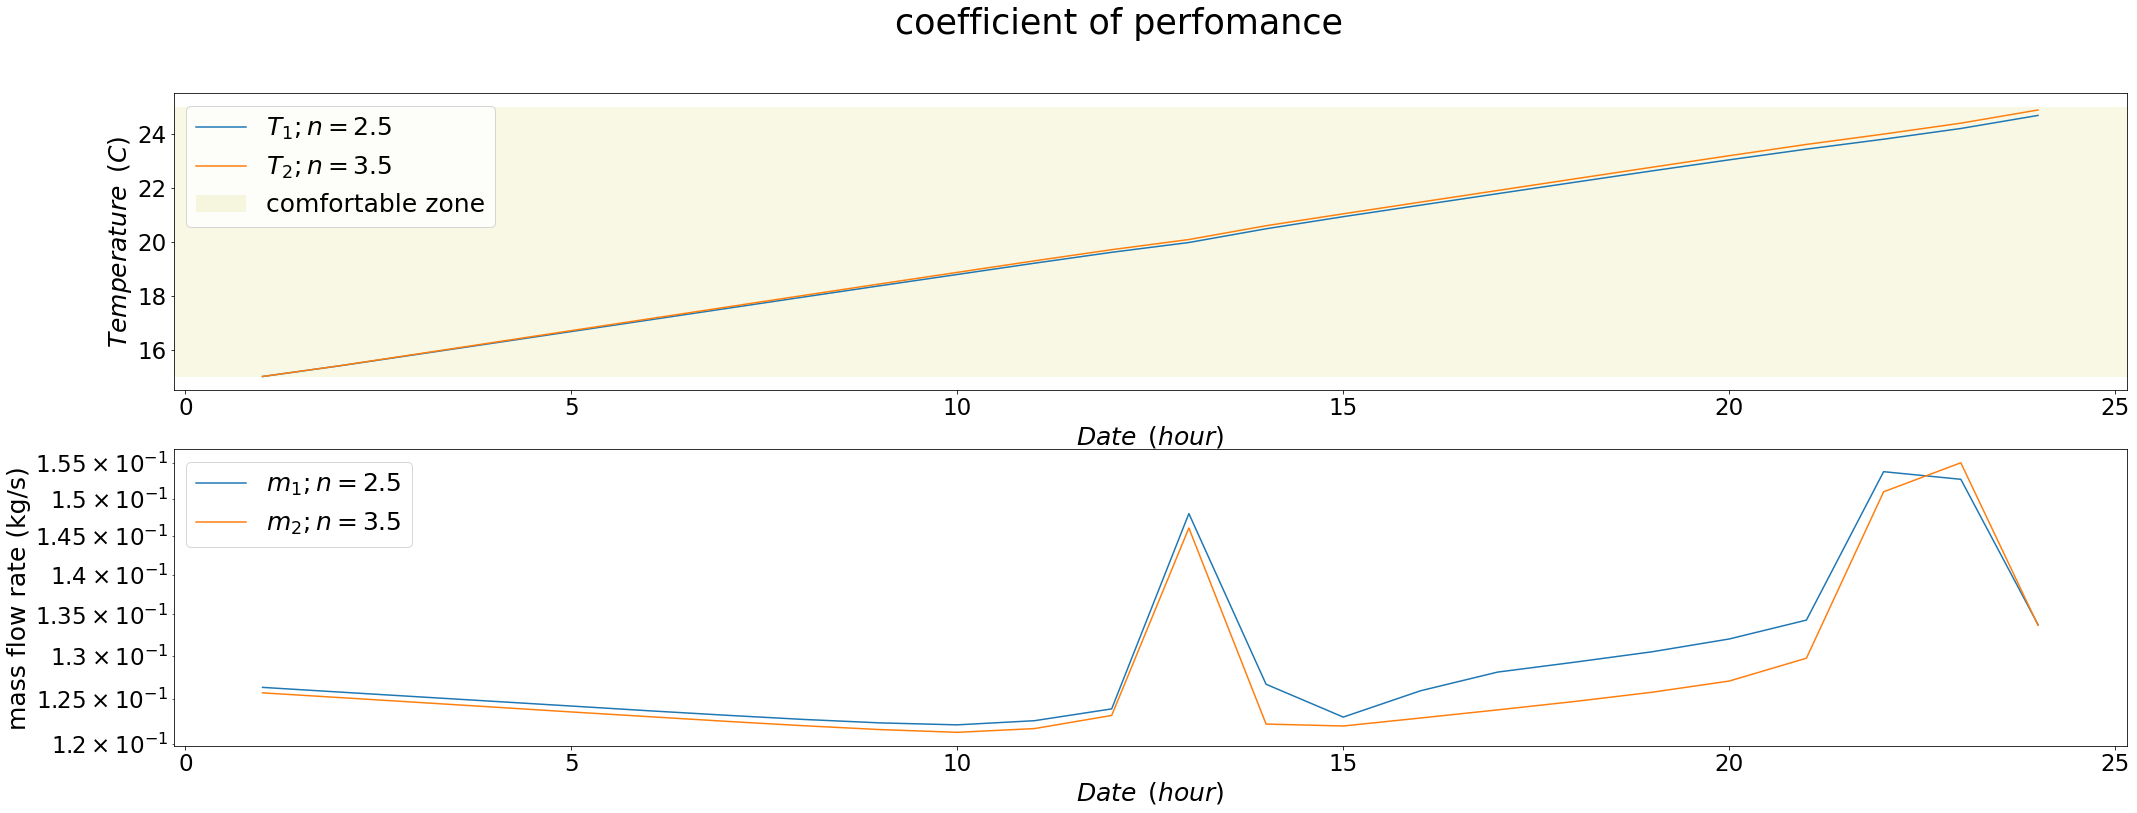

In [12]:
name_title = "coefficient of perfomance"
name_label1 = "n= 2.5"
name_label2 = "n= 3.5"
t_1, m_1 = comp_para(n= 2.5 )
t_2, m_2 = comp_para(n= 3.5 )
plot_para(t_1,t_2,m_1,m_2,name_title, name_label1, name_label2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: [1.78754335]
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration limit reached    (Exit mode 9)
            Current function value: [1.79341171]
            Iterations: 100
            Function evaluations: 1036
            Gradient evaluations: 100


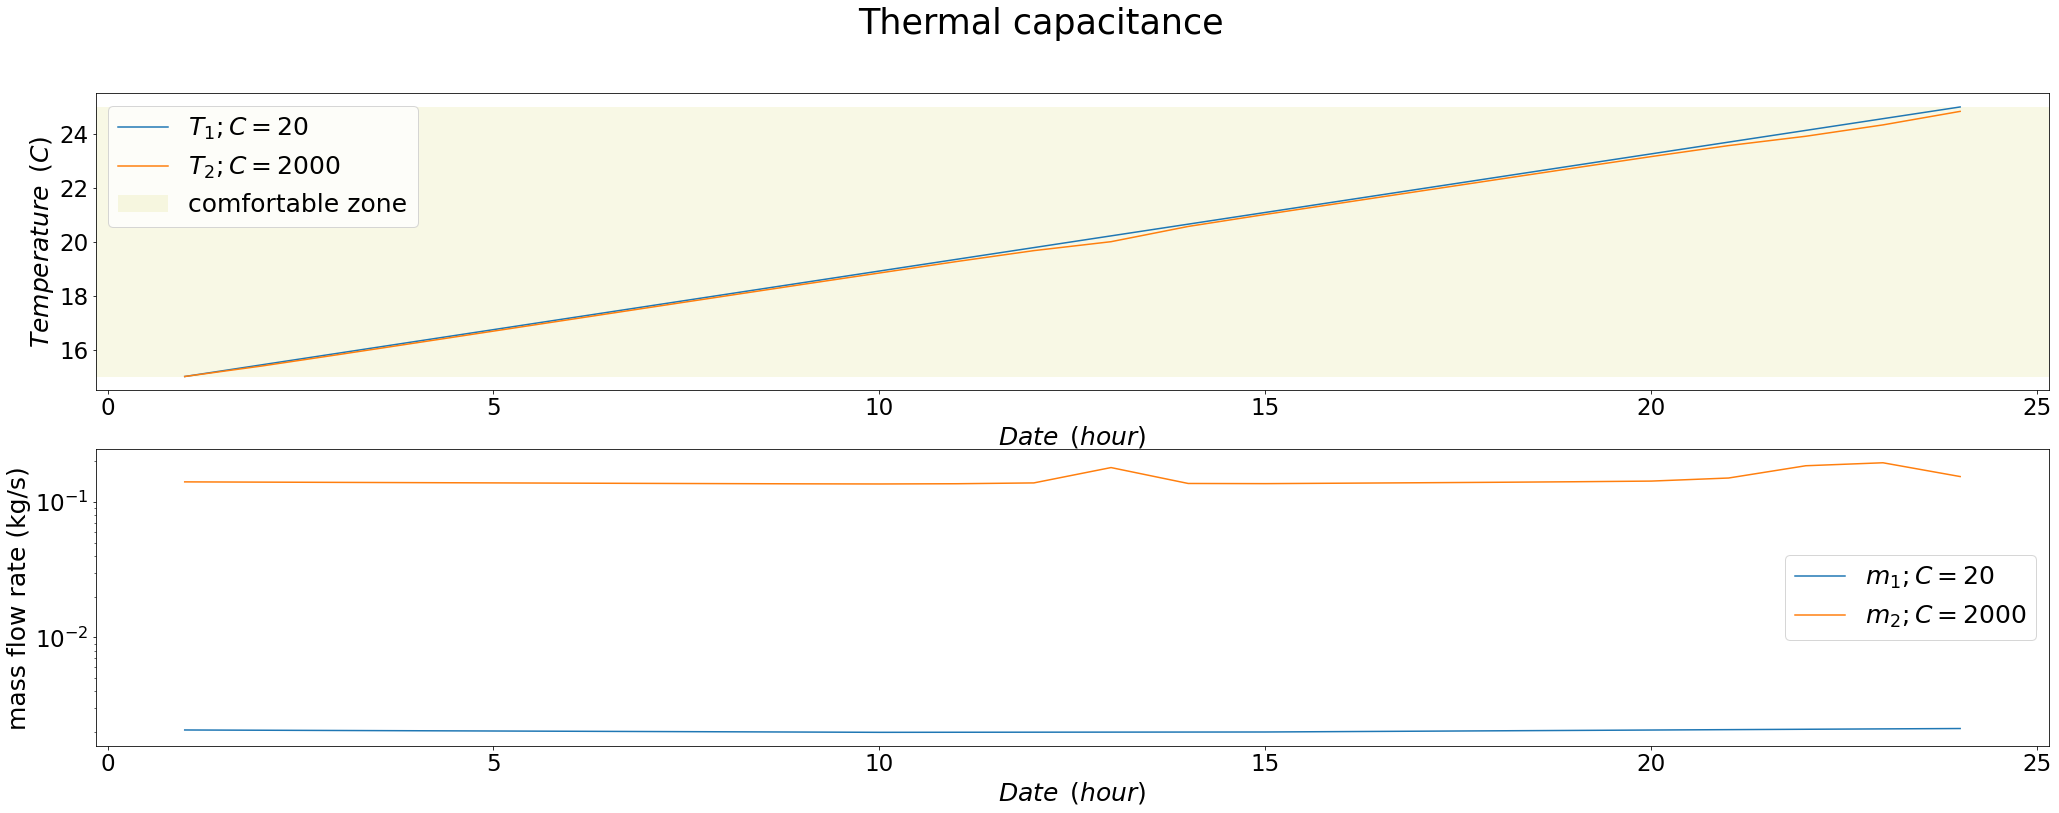

In [13]:
name_title = "Thermal capacitance"
name_label1 = "C = 20" 
name_label2 = "C = 2000"
t_1, m_1 = comp_para(C = 20)
t_2, m_2 = comp_para(C = 2000)
plot_para(t_1,t_2,m_1,m_2,name_title, name_label1, name_label2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: [1.79050193]
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: [1.78781642]
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2


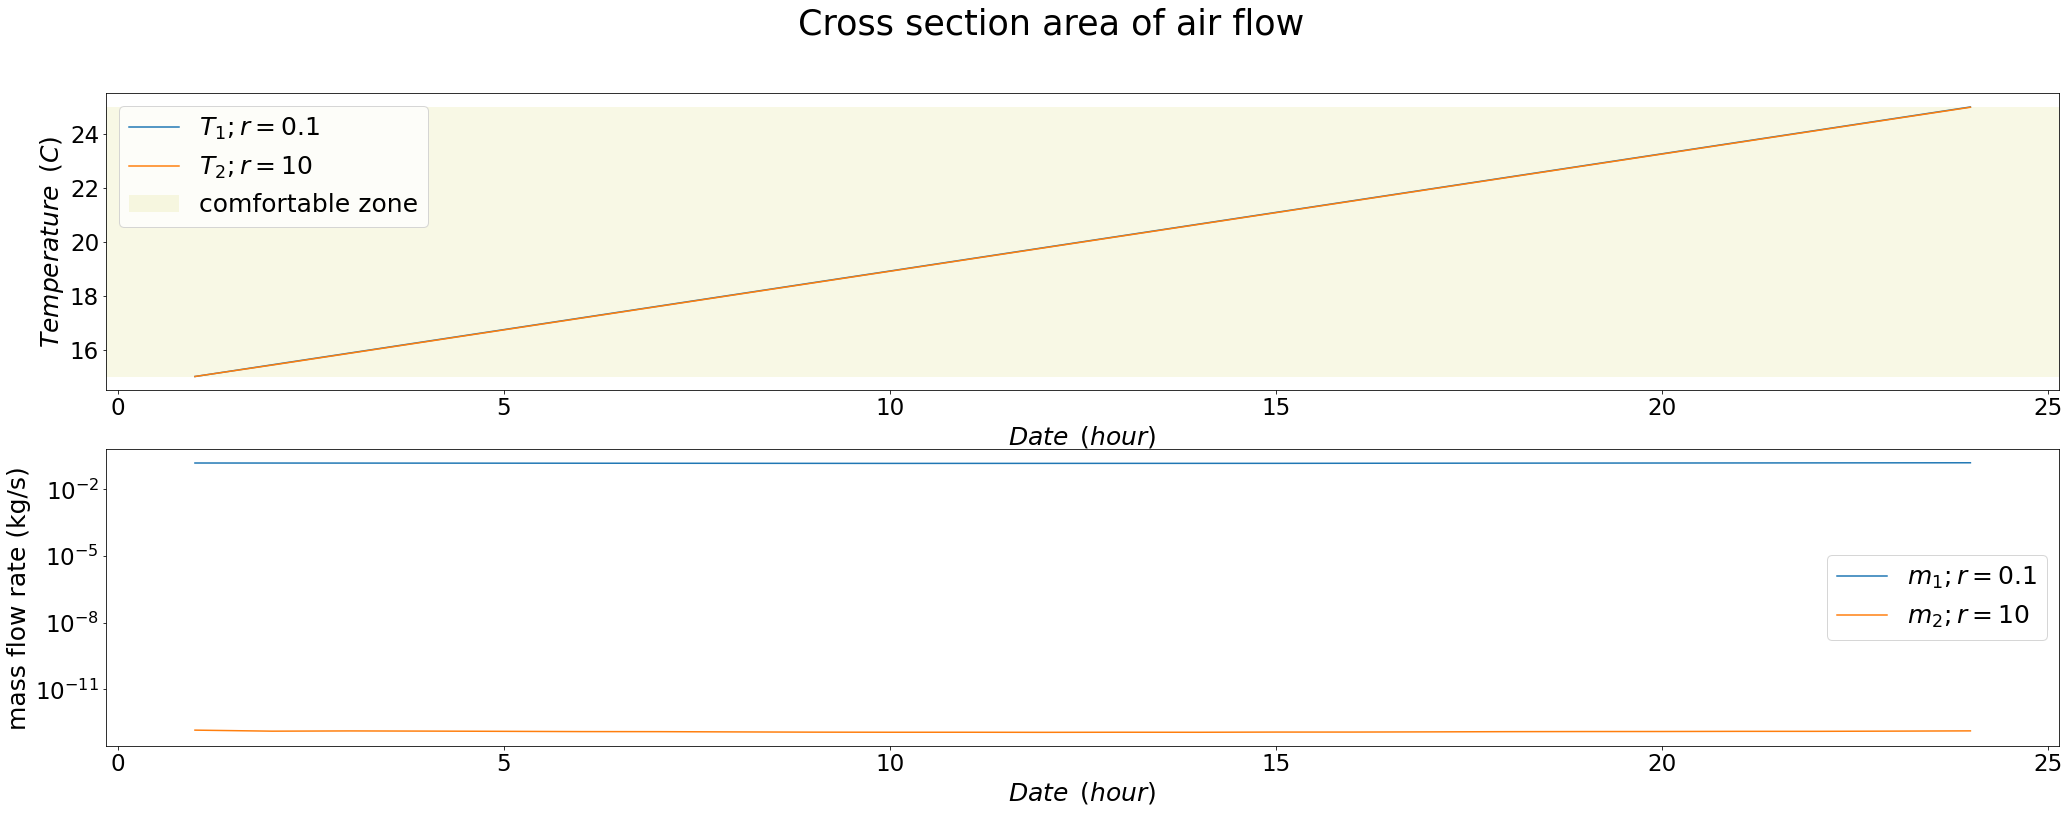

In [14]:
name_title = "Cross section area of air flow"
name_label1 = "r = 0.1" 
name_label2 = "r = 10"
t_1, m_1 = comp_para(s = math.pi * 0.1 * 0.1)
t_2, m_2 = comp_para(s = math.pi * 10 * 10)
plot_para(t_1,t_2,m_1,m_2,name_title, name_label1, name_label2)